In [1]:
%matplotlib inline
# Imports
from clr import AddReference
AddReference("System")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Jupyter")
AddReference("QuantConnect.Indicators")
from System import *
from QuantConnect import *
from QuantConnect.Data.Custom import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Jupyter import *
from QuantConnect.Indicators import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np

In [2]:
def build_events():

    """Return a pandas dataframe of the events (since the csv files always get deleted.)"""
    df = pd.DataFrame(columns=['event_date', 'day_0_date', 'ticker'])

    event_string = """1/31/2000,2/1/2000,ALK
11/12/2001,11/12/2001,AAMRQ
4/1/2011,4/2/2011,LUV
8/14/2013,8/14/2013,UPS"""

    event_list = event_string.splitlines()

    for row in event_list:
        event = row.split(',')
        df = df.append([{'event_date': event[0], 'day_0_date': event[1], 'ticker': event[2]}],
                       ignore_index=True)

    # convert date strings to datetimes
    df['day_0_date'] = pd.to_datetime(df['day_0_date'])

    return df

In [3]:
class DataProvider(object):

    def __init__(self):
        pass

    """Provide security price data specifically for this event study."""

    def get_event_window_columns(self, num_pre_event_window_periods, num_post_event_window_periods):

        """Return a list of column headers for the event window. Ex: ['-2','-1','0','1','2']"""

        cols = []
        for i in range(num_pre_event_window_periods * -1, num_post_event_window_periods + 1):
            cols.append(str(i))

        return cols

    def get_closing_prices(self, ticker, day_0_date, num_pre_event_window_periods, num_post_event_window_periods):

        """Return a pandas DataFrame of closing prices over the event window."""

        """
        
        Returns:
            pandas DataFrame, empty if no data was available. If there was data available, the 
        """

        raise NotImplementedError('subclasses must override foo()!')

In [4]:
class DataProviderESFR(DataProvider):

    """Provide security price data specifically for this event study."""

    def __init__(self):
        pass

    def get_closing_prices(self, ticker, day_0_date, num_pre_event_window_periods, num_post_event_window_periods):

        """Return a pandas DataFrame of closing prices over the event window."""

        columns = self.get_event_window_columns(num_pre_event_window_periods, num_post_event_window_periods)
        closing_prices_df = pd.DataFrame(index=[0], columns=columns)

        # Create a list of prices for the event window and fill with NaN
        prices = [np.nan for i in range(num_pre_event_window_periods + 1 + num_post_event_window_periods)]

        if ticker == 'ALK':
            prices = [14.97, 15.16, 16.03, 15.84, 16.22, 15.84, 15.78, 15.81, 15.47, 15.25, 15.10, 14.94, 14.70]
        elif ticker == 'AAMRQ':
            prices = [18.74, 18.90, 18.36, 18.55, 18.28, 18.13, 16.49, 17.01, 17.94, 18.75, 20.06, 20.77, 19.86]
        elif ticker == 'LUV':
            prices = [12.53, 12.43, 12.36, 12.66, 12.48, 12.52, 12.31, 12.05, 12.01, 11.66, 11.54, 11.64, 11.70]
        elif ticker == 'UPS':
            prices = [86.79, 86.72, 86.96, 86.65, 86.61, 86.55, 86.30, 85.43, 85.52, 85.55, 85.77, 85.56, 86.43]
        elif ticker == 'SPY':
            if day_0_date.strftime('%Y-%m-%d') == '2000-02-01':
                prices = [1401.91, 1410.03, 1404.09, 1398.56, 1360.16, 1394.46, 1409.28, 1409.12, 1424.97, 1424.37,
                          1423.00, 1441.75, 1411.71]
            elif day_0_date.strftime('%Y-%m-%d') == '2001-11-12':
                prices = [1087.20, 1102.84, 1118.86, 1115.80, 1118.54, 1120.31, 1118.33, 1139.09, 1141.21, 1142.24,
                          1138.65, 1151.06, 1142.66]
            elif day_0_date.strftime('%Y-%m-%d') == '2011-04-02':
                prices = [1313.80, 1310.19, 1319.44, 1328.26, 1325.83, 1332.41, 1332.87, 1332.63, 1335.54, 1333.51,
                          1328.17, 1324.46, 1314.16]
            elif day_0_date.strftime('%Y-%m-%d') == '2013-08-14':
                prices = [1697.37, 1690.91, 1697.48, 1691.42, 1689.47, 1694.16, 1685.39, 1661.32, 1655.83, 1646.06,
                          1652.35, 1642.80, 1656.96]

        closing_prices_df.loc[0] = prices
        return closing_prices_df

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np


class EventStudyResults(object):

    """Helper class that collects and formats the event study results.

    Attributes:
        num_starting_events (int): The number of events in the event list passed into the event study.
        num_events_processed (int): The number of events that made it into the final calculations.
        aar (pandas.Series): The average abnormal returns from the event study in a pandas.Series. The index of the
            series goes from [event_window_start : event_window_end]. ie:
                ['-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6']
            The values of the Series are float64. The first value will be a nan  since these are returns
            calculated from the previous value. ie:
                [nan, -0.00029537, 0.00117336, 0.00569039, 0.00568463, -0.01591504, -0.0294841, -0.00043875,
                0.0047285, 0.00226918, 0.01414965, 0.00387815, -0.00431594]
        caar (pandas.Series): The cumulative average abnormal returns from the event study in a pandas.Series.
            The index of the series goes from [event_window_start : event_window_end]. ie:
                ['-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6']
            The values of the Series are float64. The first value will be a nan  since these are returns
            calculated from the previous value. ie:
                [nan, -0.00029537, 0.00087799, 0.00656838, 0.01225301, -0.00366204, -0.03314613, -0.03358488,
                -0.02885638, -0.0265872, -0.01243755, -0.0085594, -0.01287535]

    """

    def __init__(self):
        self.num_starting_events = 0
        self.num_events_processed = 0
        self.aar = None
        self.caar = None
        self.std_err = None

    def plot(self, title=None, show=True, pdf_filename=None, show_errorbar=False):
        plt.clf()
        plt.figure(figsize=(15, 7.5))
        box_props = dict(facecolor='w', alpha=1.0)

        ax1 = plt.subplot(211)
        plt.title(title)
        plt.grid()
        plt.ylabel('CAAR (%)')
        ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, symbol=''))
        ax1.axhline(linewidth=1, color='k')
        x_ticks = [i for i in range(len(self.caar.index))]
        x_labels = [str(i) for i in self.caar.index]
        ax1.set_xticks(x_ticks)
        ax1.set_xticklabels(x_labels)
        plt.plot(self.caar.values, label="N=%s" % self.num_events_processed)
        caar_std_dev = self.caar.std()
        if show_errorbar:
            plt.errorbar(self.caar.index, self.caar, yerr=caar_std_dev,
                         linestyle='None', elinewidth=1, ecolor='#1f77b4', capsize=2)
        plt.legend(loc='upper right')
        textstr = 'Day 0: {0:.2f}%\nStd: {1:.3f}'.format(self.caar.loc['0'] * 100, caar_std_dev)
        ax1.text(0.02, 0.05, textstr, transform=ax1.transAxes, verticalalignment='bottom', bbox=box_props)

        ax2 = plt.subplot(212)
        plt.grid()
        x_ticks = [i for i in range(len(self.aar.index))]
        x_labels = [str(i) for i in self.aar.index]
        ax2.set_xticks(x_ticks)
        ax2.set_xticklabels(x_labels)
        ax2.axhline(linewidth=1, color='k')
        plt.plot(self.aar.values, label="N=%s" % self.num_events_processed)
        aar_std_dev = self.aar.std()
        if show_errorbar:
            plt.errorbar(self.aar.index, self.aar, yerr=aar_std_dev,
                         linestyle='None', elinewidth=1, ecolor='#1f77b4', capsize=2)
        plt.legend(loc='upper right')
        textstr = 'Day 0: {0:.2f}%\nStd: {1:.3f}'.format(self.aar.loc['0'] * 100, aar_std_dev)
        ax2.text(0.02, 0.05, textstr, transform=ax2.transAxes, verticalalignment='bottom', bbox=box_props)
        plt.ylabel('AAR (%)')
        ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, symbol=''))
        plt.xlabel('Event Window')

        plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

        if pdf_filename is not None:
            plt.savefig(pdf_filename, format='pdf')
        if show:
            plt.show()

In [6]:
class EventStudyNaiveModel(object):
    """Tool that runs an event study, calculating CAAR using the naive benchmark model."""

    def __init__(self, data_provider, event_list_df):
        """Create an event study.

        Args:
            data_provider (:obj:`EventStudyESFR`): object that gets security data
            event_list_df (:obj:`DataFrame`): Pandas DataFrame containing the list of event dates and ticker symbols.
            The ticker symbol must be in a column 'ticker'.
            For daily data, the date of day 0 must be column 'day_0_date' as a ISO8601 string (ie: YYYY-MM-DD)
        """

        self.data_provider = data_provider
        self.event_list_df = event_list_df
        self.num_pre_event_window_periods = 0
        self.num_post_event_window_periods = 0
        self.results = None


    def run_naive_model(self, market_ticker, num_pre_event_window_periods, num_post_event_window_periods):
        """Run the event study using the naive benchmark model and return the results.

        Args:
            market_ticker (str): The ticker of the model's benchmark
            num_pre_event_window_periods (int): The number of periods before the event
            num_post_event_window_periods (int): The number of periods after the event

        Returns:
            An instance of EventStudyResults.

        """

        self.results = EventStudyResults()
        self.num_pre_event_window_periods = num_pre_event_window_periods
        self.num_post_event_window_periods = num_post_event_window_periods

        # Create a DataFrame to hold all the Abnormal Returns which will be used
        # to calculate the Average Abnormal Return (AAR)
        columns = self.data_provider.get_event_window_columns(num_pre_event_window_periods,
                                                              num_post_event_window_periods)
        all_abnormal_returns_df = pd.DataFrame(columns=columns)
        #print('\nAll Abnormal Returns: \n{}'.format(all_abnormal_returns_df))

        for index, event in self.event_list_df.iterrows():

            """
            For each event:
                Get the closing prices of the securities for the event window
                Get the closing prices of the market benchamark for the event window
                Calculate the actual returns for the security.
                Calculate the market returns (ie: normal returns) for the benchmark.
                Calculate the abnormal return.
                Calculate the average abnormal return.
                Calculate the cumulative average abnormal return.
            """

            #print('\nDay Zero Date: {} ticker: {}'.format(event.day_0_date, event.ticker))

            # Get prices for the security over the event window
            security_prices_df = self.data_provider.get_closing_prices(event.ticker,
                                                                      event.day_0_date,
                                                                      self.num_pre_event_window_periods,
                                                                      self.num_post_event_window_periods)

            if security_prices_df.isnull().values.any():
                print('\n**** Prices for {} are missing around date: {} ****'.format(event.ticker, event.day_0_date))
                continue

            #print('\nSecurity prices($) for {} over the event window:\n{}'.format(event.ticker, security_prices_df.to_string(index=False)))

            # Get prices for the market benchmark over the event window
            market_prices_df = self.data_provider.get_closing_prices(market_ticker,
                                                                    event.day_0_date,
                                                                    self.num_pre_event_window_periods,
                                                                    self.num_post_event_window_periods)

            if market_prices_df.isnull().values.any():
                print('\n**** Prices for {} are missing around date: {} ****'.format(market_ticker, event.day_0_date))
                continue

            #print('\nMarket prices($) for {} over the event window:\n{}'.format(market_ticker, market_prices_df.to_string(index=False)))

            # Calculate the actual arithmetic return for the security over the event window
            actual_returns_df = security_prices_df.pct_change(axis='columns')
            #print('\nSecurity Returns(%) for {} over the event window::\n{}'.format(event.ticker,(actual_returns_df*100).round(2).to_string(index=False)))

            # Calculate the arithmetic return for the market over the event window.
            # In the naive model, this becomes the Normal Return.
            normal_returns_df = market_prices_df.pct_change(axis='columns')
            #print('\nNormal Returns(%) for {} over the event window:\n{}'.format(market_ticker,(normal_returns_df*100).round(2).to_string(index=False)))

            # Calculate the Abnormal Return over the event window
            # AR = Stock Return - Normal Return
            abnormal_returns_df = actual_returns_df.sub(normal_returns_df)
            #print('\nAbnormal Returns(%) for {} over the event window:\n{}'.format(event.ticker,(abnormal_returns_df*100).round(2).to_string(index=False)))

            # Append the AR to the other ARs so we can calculate AAR later
            all_abnormal_returns_df = pd.concat([all_abnormal_returns_df, abnormal_returns_df], ignore_index=True)

        #print('\nAR(%) for all securities over the event window:\n{}'.format((all_abnormal_returns_df*100).round(2)))
        # Calculate the Average Abnormal Returns (AAR)
        aar = all_abnormal_returns_df.mean()
        #print('\nAAR(%) for all the securities over the event window:\n{}'.format((aar*100).round(2).to_frame().T.to_string(index=False)))

        # Calculate the Cumulative Average Abnormal Returns
        caar = aar.cumsum()
        #print('\nCAAR(%) for all the securities over the event window:\n{}'.format((caar * 100).round(2).to_frame().T.to_string(index=False)))

        self.results.aar = aar
        self.results.caar = caar
        self.results.num_starting_events = self.event_list_df.shape[0]
        self.results.num_events_processed = all_abnormal_returns_df.shape[0]

        return self.results


In [7]:
def main():

    """
    This example replicates "Event Studies for Financial Research, chapter 4:
    A simplified example, the effect of air crashes on stock prices"
    using the eventstudy package.
    """

    event_list_df = build_events()
    # print('The event list:\n {}'.format(event_list_df))

    data_provider = DataProviderESFR()

    event_study = EventStudyNaiveModel(data_provider, event_list_df)

    # Run the event study looking 6 periods before the event and 6 periods after the event
    num_pre_event_window_periods = num_post_event_window_periods = 6
    market_ticker = 'SPY'
    results = event_study.run_naive_model(market_ticker, num_pre_event_window_periods, num_post_event_window_periods)

    print('\nStarted with {} events and processed {} events.'.format(results.num_starting_events,
                                                                    results.num_events_processed))

    print('\nAAR (%) for all the securities over the event window:\n{}'.format(
        (results.aar * 100).round(2).to_frame().T.to_string(index=False)))

    print('\nCAAR (%) for all the securities over the event window:\n{}'.format(
        (results.caar * 100).round(2).to_frame().T.to_string(index=False)))

    results.plot("Airline Crashes and their impact on stock returns")



Started with 4 events and processed 4 events.

AAR (%) for all the securities over the event window:
-6    -5    -4    -3    -2    -1     0     1     2     3     4     5     6
NaN -0.03  0.12  0.57  0.57 -1.59 -2.95 -0.04  0.47  0.23  1.41  0.39 -0.43

CAAR (%) for all the securities over the event window:
-6    -5    -4    -3    -2    -1     0     1     2     3     4     5     6
NaN -0.03  0.09  0.66  1.23 -0.37 -3.31 -3.36 -2.89 -2.66 -1.24 -0.86 -1.29


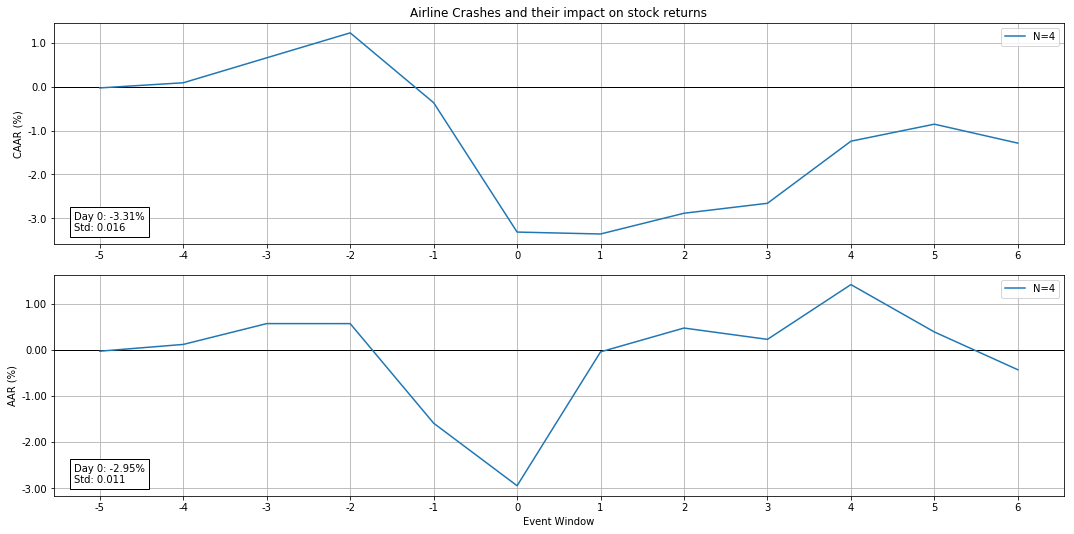

In [8]:
main()